<a href="https://colab.research.google.com/github/probml/dynamax/blob/main/dynamax/generalized_gaussian_ssm/dekf/demos/diagonal_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demos of Diagonal Approximations of EKF

This notebook compares FD-EKF, FC-EKF, VD-EKF, and SGD performances for linear/non-linear regression/classification settings.

# 0. Imports and Helper Functions

In [1]:
try:
    import dynamax
    import chex
    import flax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    print('installing chex')
    %pip install chex
    print('installing flax')
    %pip install flax
    import dynamax
    import chex
    import flax

In [14]:
from typing import Sequence
from functools import partial

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
from jax import jacfwd
from jax import vmap
from jax import jit
from jax.tree_util import tree_map, tree_reduce
import flax.linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
import chex
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jax.flatten_util import ravel_pytree
import optax
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.rebayes.diagonal_inference import (
    DEKFParams,
    _stationary_dynamics_diagonal_predict,
    _fully_decoupled_ekf_condition_on,
    stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter,
    _variational_diagonal_ekf_condition_on,
    stationary_dynamics_variational_diagonal_extended_kalman_filter,
    _jacrev_2d,
)
from dynamax.rebayes.ekf import RebayesEKF
from dynamax.rebayes.utils import MLP, get_mlp_flattened_params
from sklearn import datasets
from sklearn import preprocessing

In [54]:
def mean_callback(bel, t, x, y):
    return bel.mean

def mean_cov_callback(bel, t, x, y):
    return bel.mean, bel.cov

# EKF helper function
def run_ekf(X, Y, ekf_params, predict_fn, type='fcekf', callback=mean_callback):
    estimator = RebayesEKF(ekf_params, method = type)
    _, filtered_means = estimator.scan(X, Y, callback=callback)

    return filtered_means

# 1. Demo - Linear Regression

## 1.1 Dataset Generation

In [3]:
def generate_linreg_dataset(num_points=100, theta=jnp.array([1, 0.5]), var=0.1, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = theta[1]*X + theta[0]
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]

    return X, X_sh, Y, Y_sh, Y_tr

In [4]:
# 100 data points
X_lr_100, X_lr_100_sh, Y_lr_100, Y_lr_100_sh, Y_lr_100_tr = generate_linreg_dataset()

# 200 data points
X_lr_200, X_lr_200_sh, Y_lr_200, Y_lr_200_sh, Y_lr_200_tr = generate_linreg_dataset(200)

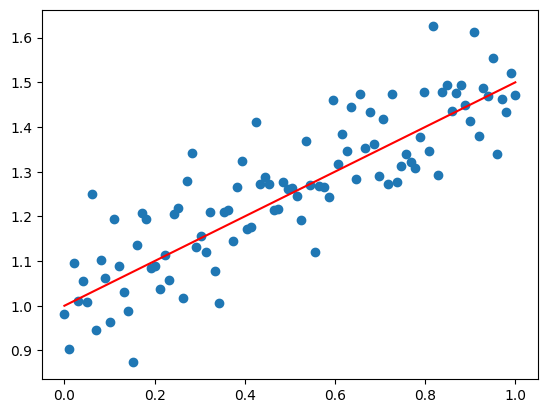

In [5]:
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, Y_lr_100_tr, c='red');

In [6]:
# Define Linear Regression as single layer perceptron
input_dim_lr, hidden_dims_lr, output_dim_lr = 1, [], 1
model_dims_lr = [input_dim_lr, *hidden_dims_lr, output_dim_lr]
_, flat_params_lr, _, apply_fn_lr = get_mlp_flattened_params(model_dims_lr)
print(flat_params_lr.shape)

(2,)


## 1.2 Full-Covariance CMGF-EKF

In [17]:
# FC-EKF for linear regression
state_dim_lr, emission_dim_lr = flat_params_lr.size, output_dim_lr
var_lr = 0.1
ekf_params_lr = ParamsGGSSM(
    initial_mean=flat_params_lr,
    initial_covariance=jnp.eye(state_dim_lr),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_lr) * 0,
    emission_mean_function = lambda w, x: apply_fn_lr(w, x),
    emission_cov_function = lambda w, x: var_lr
)
v_apply_fn_lr = vmap(apply_fn_lr, (None, 0))

fcekf_theta_lr_100 = [1.015461   0.49004573]


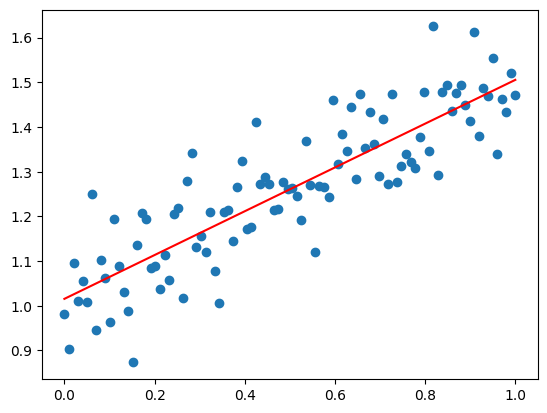

In [20]:
# 100 datapoints
fcekf_post_lr_100 = run_ekf(X_lr_100_sh, Y_lr_100_sh, ekf_params_lr, apply_fn_lr, type='fcekf')
fcekf_theta_lr_100 = fcekf_post_lr_100[-1]

print(f'fcekf_theta_lr_100 = {fcekf_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(fcekf_theta_lr_100, X_lr_100), c='red');

fcekf_theta_lr_200 = [1.0101914  0.48369384]


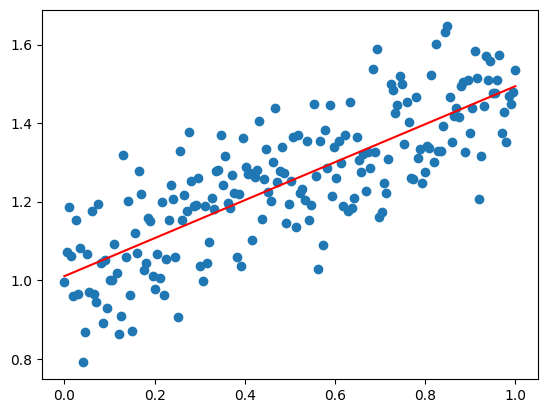

In [21]:
# 200 datapoints
fcekf_post_lr_200 = run_ekf(X_lr_200_sh, Y_lr_200_sh, ekf_params_lr, apply_fn_lr, type='fcekf')
fcekf_theta_lr_200 = fcekf_post_lr_200[-1]

print(f'fcekf_theta_lr_200 = {fcekf_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(fcekf_theta_lr_200, X_lr_200), c='red');

## 1.3 Fully-Decoupled Diagonal EKF

fdekf_theta_lr_100 = [1.0125421  0.49810666]


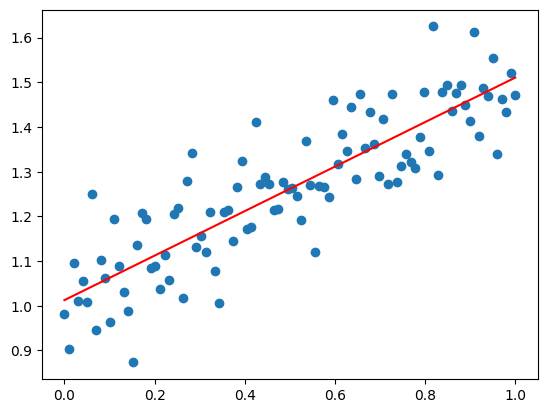

In [22]:
# 100 datapoints
fdekf_post_lr_100 = run_ekf(X_lr_100_sh, Y_lr_100_sh, ekf_params_lr, apply_fn_lr, type='fdekf')
fdekf_theta_lr_100 = fdekf_post_lr_100[-1]

print(f'fdekf_theta_lr_100 = {fdekf_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(fdekf_theta_lr_100, X_lr_100), c='red');

fdekf_theta_lr_200 = [0.9736796  0.54740214]


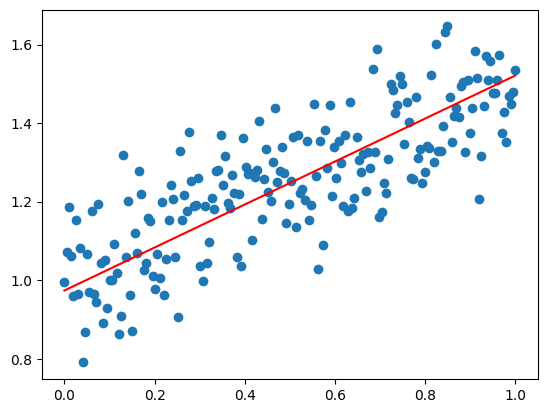

In [24]:
# 200 datapoints
fdekf_post_lr_200 = run_ekf(X_lr_200_sh, Y_lr_200_sh, ekf_params_lr, apply_fn_lr, type='fdekf')
fdekf_theta_lr_200 = fdekf_post_lr_200[-1]

print(f'fdekf_theta_lr_200 = {fdekf_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(fdekf_theta_lr_200, X_lr_200), c='red');

## 1.4 Variational Diagonal EKF

vdekf_theta_lr_100 = [0.8483305  0.78057927]


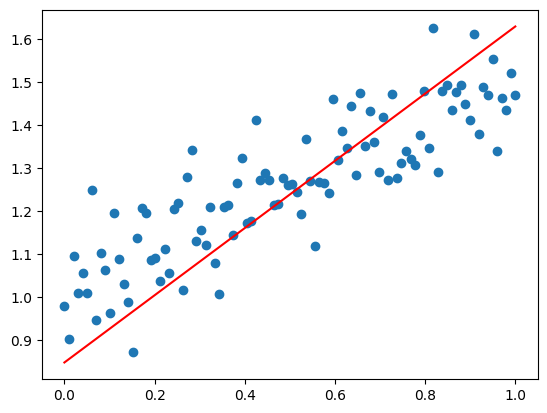

In [25]:
# 100 datapoints
vdekf_post_lr_100 = run_ekf(X_lr_100_sh, Y_lr_100_sh, ekf_params_lr, apply_fn_lr, type='vdekf')
vdekf_theta_lr_100 = vdekf_post_lr_100[-1]

print(f'vdekf_theta_lr_100 = {vdekf_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(vdekf_theta_lr_100, X_lr_100), c='red');

vdekf_theta_lr_200 = [0.90790963 0.66235775]


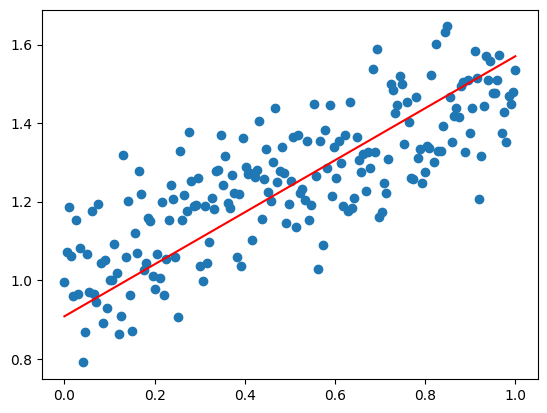

In [26]:
# 200 datapoints
vdekf_post_lr_200 = run_ekf(X_lr_200_sh, Y_lr_200_sh, ekf_params_lr, apply_fn_lr, type='vdekf')
vdekf_theta_lr_200 = vdekf_post_lr_200[-1]

print(f'vdekf_theta_lr_200 = {vdekf_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(vdekf_theta_lr_200, X_lr_200), c='red');

## 1.5 SGD - Single Pass

In [27]:
# Generic loss function
def loss_optax(params, x, y, loss_fn, apply_fn):
    y, y_hat = jnp.atleast_1d(y), apply_fn(params, x)
    loss_value = loss_fn(y, y_hat)
    return loss_value.mean()

In [28]:
# SGD fit function
def fit_optax(params, optimizer, input, output, loss_fn, num_epochs=200):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, x, y):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(zip(input, output)):
            params, opt_state, loss_value = step(params, opt_state, x, y)
    
    return params

# Define SGD optimizer
sgd_optimizer = optax.sgd(learning_rate=1e-2)

In [29]:
# L2 loss function for linear regression
loss_fn_lr = partial(loss_optax, loss_fn = optax.l2_loss, apply_fn = apply_fn_lr)

sgd_sp_theta_lr_100 = [0.7841333  0.24538857]


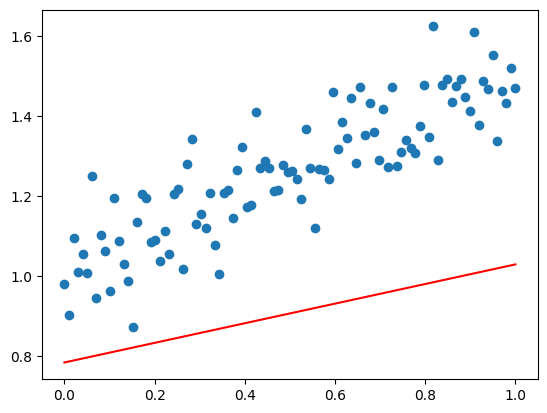

In [30]:
# 100 datapoints
sgd_sp_theta_lr_100 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_100, Y_lr_100, loss_fn_lr, num_epochs=1)
print(f'sgd_sp_theta_lr_100 = {sgd_sp_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(sgd_sp_theta_lr_100, X_lr_100), c='red');

sgd_sp_theta_lr_100 = [1.0464455  0.28148997]


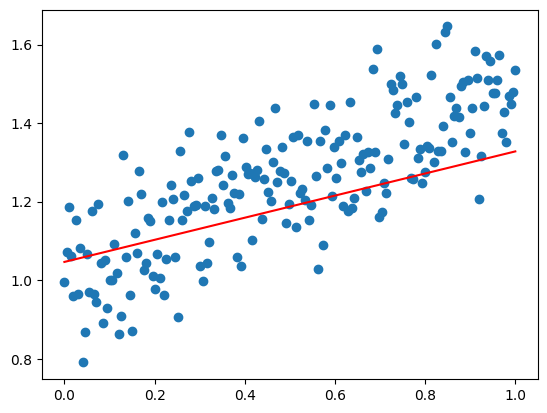

In [31]:
# 200 datapoints
sgd_sp_theta_lr_200 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_200, Y_lr_200, loss_fn_lr, num_epochs=1)
print(f'sgd_sp_theta_lr_100 = {sgd_sp_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(sgd_sp_theta_lr_200, X_lr_200), c='red');

## 1.6 SGD - Multi Pass (200 Epochs)

sgd_mp_theta_lr_100 = [1.0177526 0.4867086]


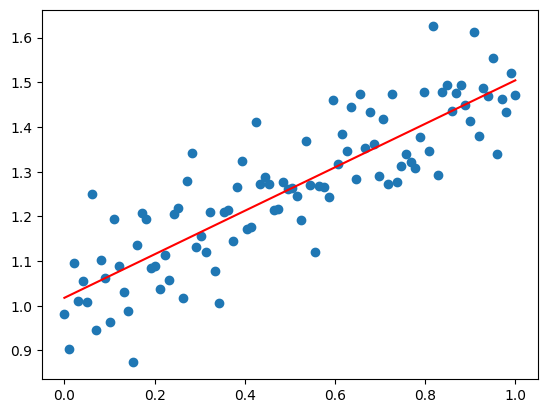

In [32]:
# 100 datapoints
sgd_mp_theta_lr_100 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_100, Y_lr_100, loss_fn_lr)
print(f'sgd_mp_theta_lr_100 = {sgd_mp_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(sgd_mp_theta_lr_100, X_lr_100), c='red');

sgd_mp_theta_lr_200 = [1.0130821 0.477784 ]


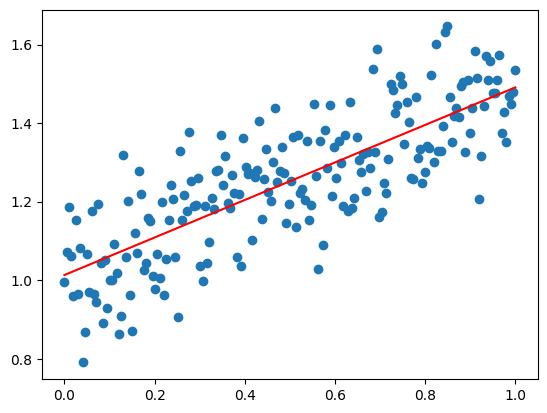

In [33]:
# 200 datapoints
sgd_mp_theta_lr_200 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_200, Y_lr_200, loss_fn_lr)
print(f'sgd_mp_theta_lr_200 = {sgd_mp_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(sgd_mp_theta_lr_200, X_lr_200), c='red');

# 2. Demo - Nonlinear Regression

## 2.1 Dataset Generation

In [34]:
def generate_nonlinreg_dataset(num_points=400, fn=lambda x: jnp.sin(5*x**2 - 1), var=0.1, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = vmap(fn)(X)
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]
    return X, X_sh, Y, Y_sh, Y_tr

In [35]:
X_nr, X_nr_sh, Y_nr, Y_nr_sh, Y_nr_tr = generate_nonlinreg_dataset()

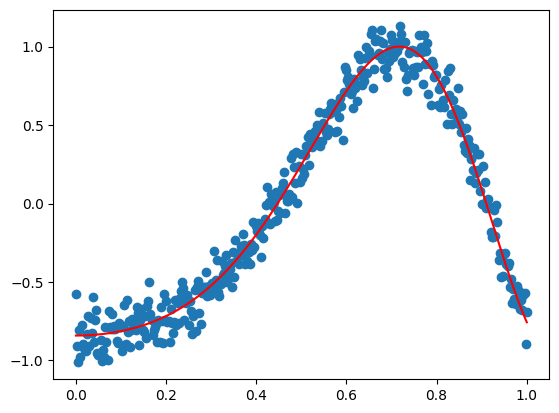

In [36]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, Y_nr_tr, c='red');

In [37]:
# Define Linear Regression as MLP with one hidden layer
input_dim_nr, hidden_dims_nr, output_dim_nr = 1, [15, 15], 1
model_dims_nr = [input_dim_nr, *hidden_dims_nr, output_dim_nr]
_, flat_params_nr, _, apply_fn_nr = get_mlp_flattened_params(model_dims_nr)
print(flat_params_nr.shape)

(286,)


## 2.2 Full-Covariance CMGF-EKF

In [38]:
# FC-EKF for nonlinear regression
state_dim_nr, emission_dim_nr = flat_params_nr.size, output_dim_nr
var_nr = 0.1
ekf_params_nr = ParamsGGSSM(
    initial_mean=flat_params_nr,
    initial_covariance=jnp.eye(state_dim_nr),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_nr) * 0,
    emission_mean_function = lambda w, x: apply_fn_nr(w, x),
    emission_cov_function = lambda w, x: var_nr
)
v_apply_fn_nr = vmap(apply_fn_nr, (None, 0))

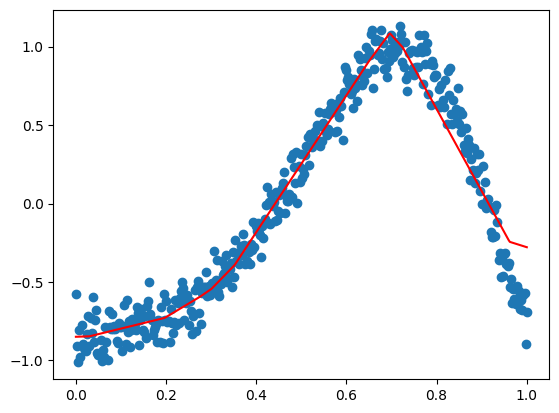

In [39]:
fcekf_post_nr = run_ekf(X_nr_sh, Y_nr_sh, ekf_params_nr, apply_fn_nr, type='fcekf')
fcekf_weight_nr = fcekf_post_nr[-1]
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(fcekf_weight_nr, X_nr), c='red');

## 2.3 Fully-Decoupled Diagonal EKF

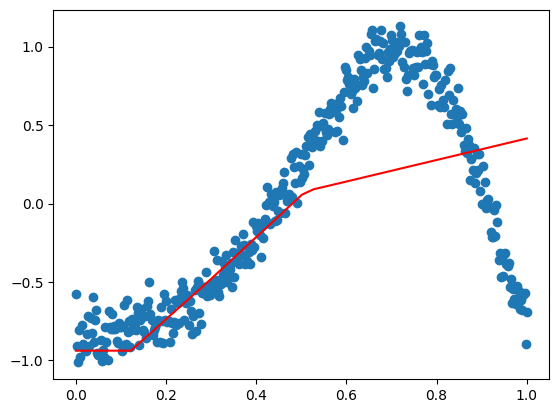

In [40]:
fdekf_post_nr = run_ekf(X_nr_sh, Y_nr_sh, ekf_params_nr, apply_fn_nr, type='fdekf')
fdekf_weight_nr = fdekf_post_nr[-1]
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(fdekf_weight_nr, X_nr), c='red');

## 2.4 Variational Diagonal EKF

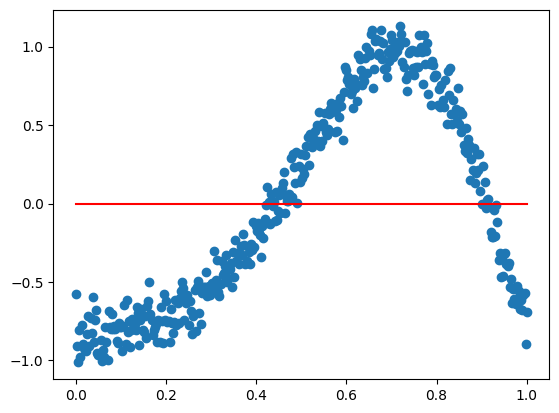

In [41]:
vdekf_post_nr = run_ekf(X_nr_sh, Y_nr_sh, ekf_params_nr, apply_fn_nr, type='vdekf')
vdekf_weight_nr = vdekf_post_nr[-1]
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(vdekf_weight_nr, X_nr), c='red');

## 2.5 SGD - Single Pass

In [42]:
# L2 loss function for nonlinear regression
loss_fn_nr = partial(loss_optax, loss_fn = optax.l2_loss, apply_fn = apply_fn_nr)

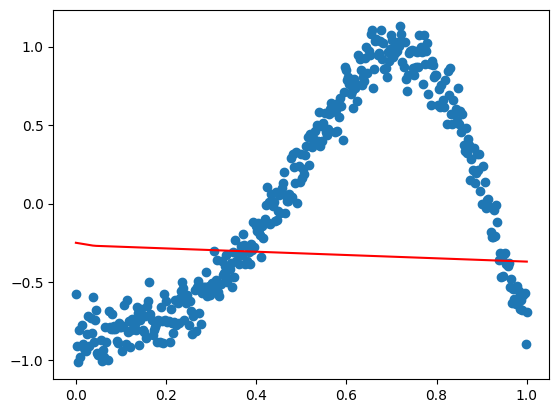

In [43]:
sgd_sp_nr = fit_optax(flat_params_nr, sgd_optimizer, X_nr, Y_nr, loss_fn_nr, num_epochs=1)
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(sgd_sp_nr, X_nr), c='red');

## 2.6 SGD - Multi Pass (200 Epochs)

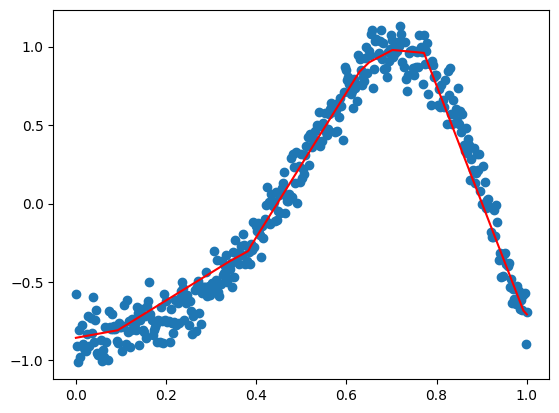

In [44]:
sgd_mp_nr = fit_optax(flat_params_nr, sgd_optimizer, X_nr, Y_nr, loss_fn_nr, num_epochs=200)
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(sgd_mp_nr, X_nr), c='red');

# 3. Demo - Linearly-Separable Classification

## 3.1 Dataset Generation

In [45]:
def generate_input_grid(input):
    """Generate grid on input space.
    Args:
        input (DeviceArray): Input array to determine the range of the grid.
    Returns:
        input_grid: Generated input grid.
    """    
    # Define grid limits
    xmin, ymin = input.min(axis=0) - 0.1
    xmax, ymax = input.max(axis=0) + 0.1

    # Define grid
    step = 0.1
    x_grid, y_grid = jnp.meshgrid(jnp.mgrid[xmin:xmax:step], jnp.mgrid[ymin:ymax:step])
    input_grid = jnp.concatenate([x_grid[...,None], y_grid[...,None]], axis=2)

    return input_grid

In [46]:
def posterior_predictive_grid_ekf(grid, mean, cov, apply, binary=False, ekf_type='fcekf', 
                                  num_samples=100,key=0):
    """Compute posterior predictive probability for each point in grid
    Args:
        grid (DeviceArray): Grid on which to predict posterior probability.
        mean (DeviceArray): Posterior mean of parameters.
        cov (DeviceArray): Posterior cov of parameters.
        apply (Callable): Apply function for MLP.
        binary (bool, optional): Flag to determine whether to round probabilities to binary outputs. Defaults to True.
    Returns:
        _type_: _description_
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    if ekf_type == 'fcekf':
        mvn = MVN(loc=mean, covariance_matrix=cov)
    else:
        mvn = MVND(loc=mean, scale_diag=cov)
    # Sample parameters
    sampled_params = mvn.sample(seed=key, sample_shape=num_samples)
    
    def posterior_predictive_single_param(param):
        inferred_fn = lambda x: apply(param, x)
        fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
        Z = fn_vec(grid)
        if binary:
            Z = jnp.rint(Z)
        return Z
    
    Zs = vmap(posterior_predictive_single_param, (0,))(sampled_params)
    return Zs.mean(axis=0)

In [47]:
def posterior_predictive_grid(grid, mean, apply, binary=False):
    """Compute posterior predictive probability for each point in grid
    Args:
        grid (DeviceArray): Grid on which to predict posterior probability.
        mean (DeviceArray): Posterior mean of parameters.
        apply (Callable): Apply function for MLP.
        binary (bool, optional): Flag to determine whether to round probabilities to binary outputs. Defaults to True.
    Returns:
        _type_: _description_
    """    
    inferred_fn = lambda x: apply(mean, x)
    fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
    Z = fn_vec(grid)
    if binary:
        Z = jnp.rint(Z)
    return Z

In [48]:
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    """Plot the 2d posterior predictive distribution.
    Args:
        ax (axis): Matplotlib axis.
        X (DeviceArray): Input array.
        title (str): Title for the plot.
        colors (list): List of colors that correspond to each element in X.
        Xspace (DeviceArray, optional): Input grid to predict on. Defaults to None.
        Zspace (DeviceArray, optional): Predicted posterior on the input grid. Defaults to None.
        cmap (str, optional): Matplotlib colormap. Defaults to "viridis".
    """    
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    plt.tight_layout()
    return ax

In [49]:
def generate_linearly_separable_dataset(num_per_class=250, key=1):
    X, y = datasets.make_blobs(n_samples=500, centers=2, n_features=2, center_box=(0, 10), random_state=key)
    scaler = preprocessing.StandardScaler()
    X = jnp.array(scaler.fit_transform(X))
    y = jnp.array(y.astype('float'))
    return X, y

In [50]:
X_lc, Y_lc = generate_linearly_separable_dataset()

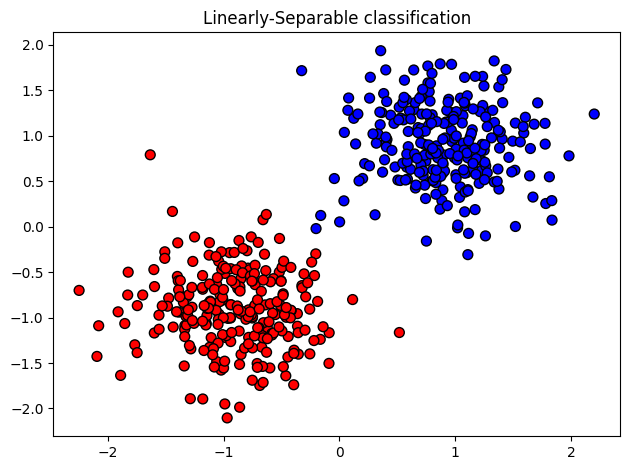

In [51]:
fig, ax = plt.subplots()
plot_posterior_predictive(ax, X_lc, Y_lc, "Linearly-Separable classification");

In [52]:
# MLP for linearly-separable classification
input_dim_lc, hidden_dims_lc, output_dim_lc = 2, [5, 5], 1
model_dims_lc = [input_dim_lc, *hidden_dims_lc, output_dim_lc]
_, flat_params_lc, _, apply_fn_lc = get_mlp_flattened_params(model_dims_lc)
print(flat_params_lc.shape)

(51,)


## 3.2 Full Covariance CMGF-EKF

In [53]:
# CMGF-EKF for MLP Classifier
state_dim_lc, emission_dim_lc = flat_params_lc.size, output_dim_lc
eps_lc = 1e-4
sigmoid_fn_lc = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn_lc(w, x)), eps_lc, 1-eps_lc) # Clip to prevent divergence
ekf_params_lc = ParamsGGSSM(
    initial_mean=flat_params_lc,
    initial_covariance=jnp.eye(state_dim_lc),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_lc) * 0,
    emission_mean_function = lambda w, x: sigmoid_fn_lc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_lc(w, x) * (1 - sigmoid_fn_lc(w, x))
)

In [57]:
fcekf_post_lc = run_ekf(X_lc, Y_lc, ekf_params_lc, sigmoid_fn_lc, type='fcekf', callback=mean_cov_callback)
fcekf_weight_lc, fcekf_cov_lc = fcekf_post_lc[0][-1], fcekf_post_lc[1][-1]

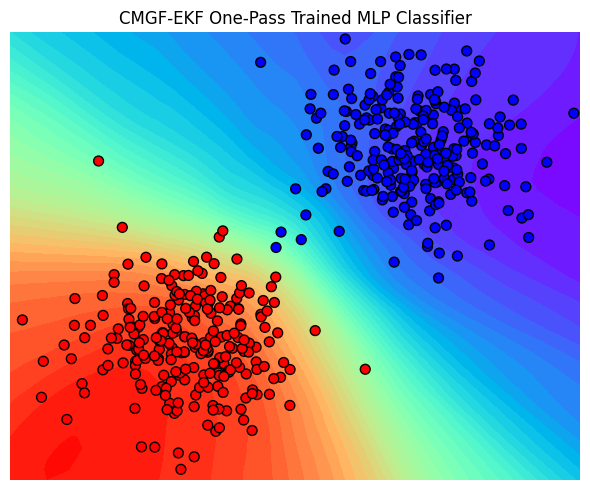

In [59]:
input_grid_lc = generate_input_grid(X_lc)

# Evaluate the trained MLP on grid and plot
Z_fcekf_lc = posterior_predictive_grid_ekf(input_grid_lc, fcekf_weight_lc, fcekf_cov_lc, sigmoid_fn_lc)
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_fcekf_lc);

## 3.3 Fully-Decoupled Diagonal EKF

In [60]:
fdekf_post_lc = run_ekf(X_lc, Y_lc, ekf_params_lc, sigmoid_fn_lc, type='fdekf', callback=mean_cov_callback)
fdekf_weight_lc, fdekf_cov_lc = fdekf_post_lc[0][-1], fdekf_post_lc[1][-1]

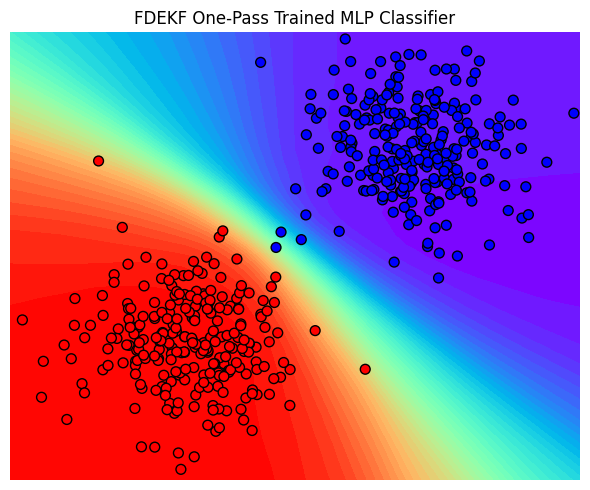

In [61]:
# Evaluate the trained MLP on grid and plot
Z_fdekf_lc = posterior_predictive_grid_ekf(input_grid_lc, fdekf_weight_lc, fdekf_cov_lc, sigmoid_fn_lc, binary=False,
                                       ekf_type='fdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "FDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_fdekf_lc);

## 3.4 Variational Diagonal EKF

In [62]:
vdekf_post_lc = run_ekf(X_lc, Y_lc, ekf_params_lc, sigmoid_fn_lc, type='vdekf', callback=mean_cov_callback)
vdekf_weight_lc, vdekf_cov_lc = vdekf_post_lc[0][-1], vdekf_post_lc[1][-1]

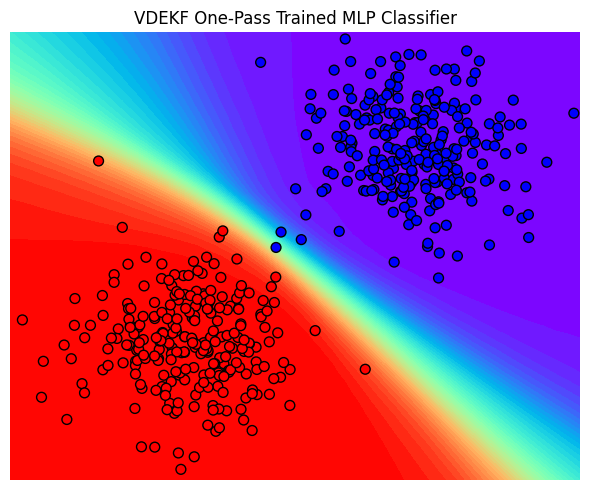

In [63]:
# Evaluate the trained MLP on grid and plot
Z_vdekf_lc = posterior_predictive_grid_ekf(input_grid_lc, vdekf_weight_lc, 
                                       vdekf_cov_lc, sigmoid_fn_lc, binary=False, ekf_type='vdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "VDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_vdekf_lc);

## 3.5 SGD - Single Pass

In [64]:
# Cross entropy loss for linear classification
loss_fn_lc = partial(loss_optax, loss_fn = lambda y, yhat: -(y * jnp.log(yhat) + (1-y) * jnp.log(1 - yhat)), 
                     apply_fn = sigmoid_fn_lc)

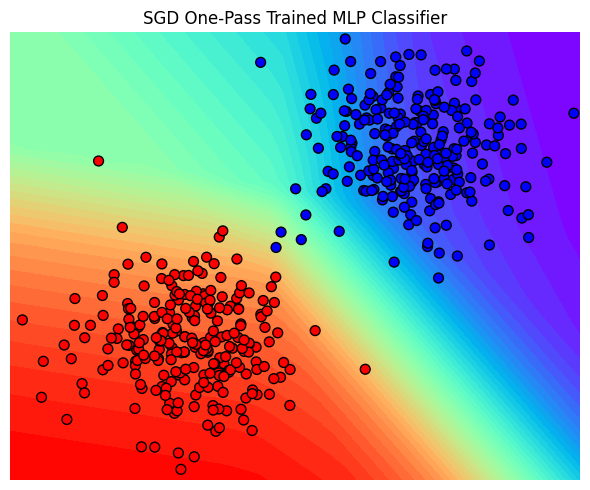

In [65]:
sgd_sp_lc = fit_optax(flat_params_lc, sgd_optimizer, X_lc, Y_lc, loss_fn_lc, num_epochs=1)

# Evaluate the trained MLP on grid and plot
Z_sgd_sp_lc = posterior_predictive_grid(input_grid_lc, sgd_sp_lc, sigmoid_fn_lc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_sgd_sp_lc);

## 3.6 SGD - Multi Pass (200 Epochs)

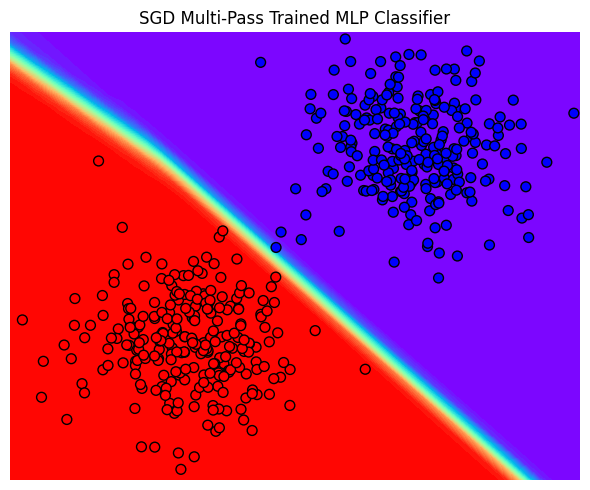

In [66]:
sgd_mp_lc = fit_optax(flat_params_lc, sgd_optimizer, X_lc, Y_lc, loss_fn_lc, num_epochs=200)

# Evaluate the trained MLP on grid and plot
Z_sgd_mp_lc = posterior_predictive_grid(input_grid_lc, sgd_mp_lc, sigmoid_fn_lc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD Multi-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_sgd_mp_lc);

# 4. Demo - Nonlinear Classification

The demo for nonlinear classification using the half-moons dataset is contained in a separate notebook, `half_moons_demo.ipynb`.